In [1]:
import os
import sys
import time

verbose  = os.environ.get('RADICAL_PILOT_VERBOSE', 'REPORT')
os.environ['RADICAL_PILOT_VERBOSE'] = verbose

import radical.pilot as rp
import radical.utils as ru

from rose.rl.learner import SequentialReinforcementLearner
from rose.engine import Task, ResourceEngine
from rose.metrics import GREATER_THAN_THRESHOLD

In [2]:
engine = ResourceEngine({'runtime': 30,
                         'resource': 'local.localhost'})
rl = SequentialReinforcementLearner(engine)
code_path = f'{sys.executable} {os.getcwd()}'
data_path = os.path.join(os.getcwd(), 'data')
os.makedirs(data_path, exist_ok=True)

Resource Engine started successfully

Task 'environment' ready to submit; resolved dependencies: []
submitting ['environment'] for execution
task.000000 is DONE
Task 'update' ready to submit; resolved dependencies: ['environment']
submitting ['update'] for execution
task.000001 is DONE
Task 'check_reward' ready to submit; resolved dependencies: ['update']
submitting ['check_reward'] for execution
task.000002 is DONE
Task 'environment' ready to submit; resolved dependencies: []
submitting ['environment'] for execution
task.000003 is DONE
Task 'update' ready to submit; resolved dependencies: ['environment']
submitting ['update'] for execution
task.000004 is DONE
Task 'check_reward' ready to submit; resolved dependencies: ['update']
submitting ['check_reward'] for execution
task.000005 is DONE
Task 'environment' ready to submit; resolved dependencies: []
submitting ['environment'] for execution
task.000006 is DONE
Task 'update' ready to submit; resolved dependencies: ['environment']
submi

In [3]:
# Define and register the environment task
@rl.environment_task
def environment(*args):
    return Task(executable=f'{code_path}/simulate.py --data-dir {data_path}', arguments=args)

# Define and register the policy update task
@rl.update_task
def update(*args):
    return Task(executable=f'{code_path}/train.py --data-dir {data_path}', arguments=args)

@rl.as_stop_criterion(metric_name='MODEL_REWARD', threshold=200, operator=GREATER_THAN_THRESHOLD)
def check_reward(*args):
    return Task(executable=f'{code_path}/test_model.py --data-dir {data_path}', arguments=args)

In [4]:
env = environment()
upd = update()
stop_cond = check_reward()

In [5]:
rl.learn(max_iter=50)

Starting Iteration-0
Registered task 'environment' and id of 000000 with dependencies: []
Registered task 'update' and id of 000001 with dependencies: ['environment']
Registered task 'check_reward' and id of 000002 with dependencies: ['update']
stop criterion metric: MODEL_REWARD is not met yet (0.01).
Starting Iteration-1
Registered task 'environment' and id of 000003 with dependencies: []
Registered task 'update' and id of 000004 with dependencies: ['environment']
Registered task 'check_reward' and id of 000005 with dependencies: ['update']
stop criterion metric: MODEL_REWARD is not met yet (8.44).
Starting Iteration-2
Registered task 'environment' and id of 000006 with dependencies: []
Registered task 'update' and id of 000007 with dependencies: ['environment']
Registered task 'check_reward' and id of 000008 with dependencies: ['update']
stop criterion metric: MODEL_REWARD is not met yet (16.39).
Starting Iteration-3
Registered task 'environment' and id of 000009 with dependencies: 

In [6]:
engine.shutdown()

Shutdown is triggered, terminating the resources gracefully


Text(0.5, 1.0, 'Reward Values for Cart Pole')

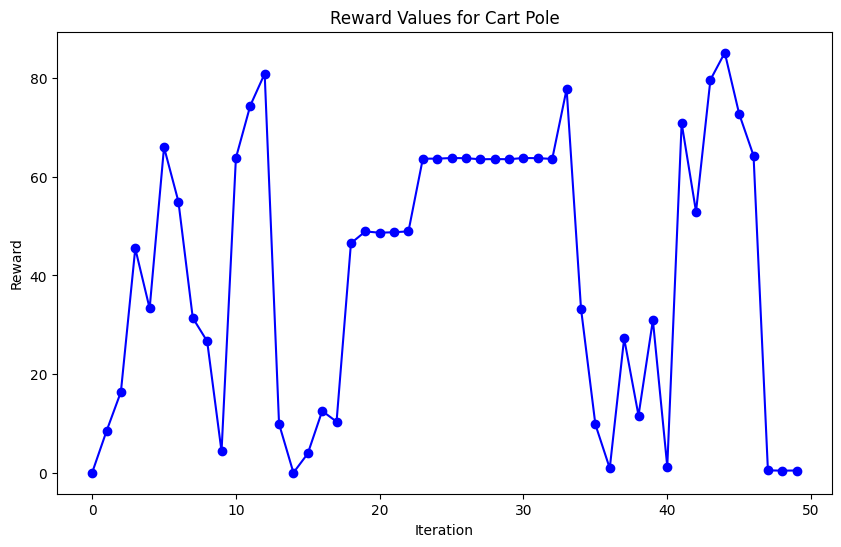

In [7]:
import matplotlib.pyplot as plt
reward_values = rl.get_result(task_name='check_reward')
reward_values = [float(reward.strip()) for reward in reward_values]

plt.figure(figsize=(10, 6))
plt.plot(reward_values, marker='o', color='b', linestyle='-', markersize=6)

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward Values for Cart Pole')